## Grand Mesa Demo

Process ATL03 data from the Grand Mesa region and produce a customized ATL06 elevation dataset.

### What is demonstrated

* The `icesat2.atl06p` API is used to perform a SlideRule parallel processing request of the Grand Mesa region
* The `icesat2.cmr` and `icesat2.h5` API's are used to manually retrieve specific ATL06 datasets corresponding to the Grand Mesa region
* The `pyproj` and `shapely` packages are used to subset ATL06 data that was manually retrieved
* The `matplotlib` and `cartopy` packages are used to plot the data processed by SlideRule alongside the manually retrieved and subsetted data

### Points of interest

The resulting datasets plotted at the bottom of the notebook show that existing ATL06 data is not available for the entire Grand Mesa region.  By using the SlideRule API to process ATL03 data and produce a customized ATL06 dataset, elevation data can be returned for the entire region of interest.

In [1]:
import sys
import logging
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import time
from datetime import datetime
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
import concurrent.futures
from sliderule import icesat2
from sliderule import sliderule

In [2]:
# Configure Logging
icesat2_logger = logging.getLogger("sliderule.icesat2")
icesat2_logger.setLevel(logging.INFO)
# Create Console Output
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
icesat2_logger.addHandler(ch)

## SlideRule Configuration

In [3]:
# Configure ICESat-2 API
icesat2.init("icesat2sliderule.org", False)
# Configure Region of Interest
region = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
           {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
           {"lon": -107.7818591266989, "lat": 39.26613714985466},
           {"lon": -108.3605610678553, "lat": 39.25086131372244},
           {"lon": -108.3435200747503, "lat": 38.89102961045247} ]

## Calculate ATL06-SR Elevations using SlideRule

In [4]:
# Latch Start Time
perf_start = time.perf_counter()

# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# Request ATL06 Data
rsps = icesat2.atl06p(parms, "atlas-s3")

# Latch Stop Time
perf_stop = time.perf_counter()

# Build Dataframe of SlideRule Responses
df = pd.DataFrame(rsps)

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time". format(perf_duration))
print("Reference Ground Tracks: {}".format(df["rgt"].unique()))
print("Cycles: {}".format(df["cycle"].unique()))
print("Received {} elevations".format(len(df)))

Identified 66 resources to process
Allocating 12 workers across 2 processing nodes
unable to process resource ATL03_20181110092841_06530106_003_01.h5: no elements
Results returned for 1 out of 66 resources
unable to process resource ATL03_20190209050825_06530206_003_01.h5: no elements
Results returned for 2 out of 66 resources
unable to process resource ATL03_20190112181620_02340202_003_01.h5: no elements
Results returned for 3 out of 66 resources
Results returned for 4 out of 66 resources
unable to process resource ATL03_20190214164413_07370202_003_01.h5: no elements
Results returned for 5 out of 66 resources
Results returned for 6 out of 66 resources
Results returned for 7 out of 66 resources
unable to process resource ATL03_20190116180755_02950202_003_01.h5: no elements
Results returned for 8 out of 66 resources
Results returned for 9 out of 66 resources
Results returned for 10 out of 66 resources
Results returned for 11 out of 66 resources
Results returned for 12 out of 66 resource

Completed in 28.035 seconds of wall-clock time
Reference Ground Tracks: [ 211 1156  714  295  737 1179]
Cycles: [2 1 3 4 5 6 7 8]
Received 180918 elevations


## Retrieve ATL06 Elevations Directly using `icesat2.h5p` API

This method of reading H5 data directly is the recommended method and runs faster than `icesat2.h5` as each dataset is read in parallel on the server and shares a common cache. The code below has a couple other optimizations including only sampling every 10th coordinate for point inclusion, and reading the lat,lon information first and then reading only the necessary heights.

In [5]:
# read ATL06 resource and return heights within polygon
def subsetted_read(resource, polygon, transformer):

    heights = []
    latitudes = []
    longitudes = []
    api_time = 0

    try:

        # List of tracks to read
        tracks = ["1l", "1r", "2l", "2r", "3l", "3r"]

        # Build list of each lat,lon dataset to read
        geodatasets = []
        for track in tracks:
            prefix = "/gt"+track+"/land_ice_segments/"
            geodatasets.append({"dataset": prefix+"latitude", "startrow": 0, "numrows": -1})
            geodatasets.append({"dataset": prefix+"longitude", "startrow": 0, "numrows": -1})

        # Read lat,lon from resource
        api_start = time.perf_counter()
        geocoords = icesat2.h5p(geodatasets, resource, "atlas-s3")
        api_stop = time.perf_counter()
        api_time += (api_stop - api_start)

        # Build list of the subsetted h_li datasets to read
        hidatasets = []
        for track in tracks:
            prefix = "/gt"+track+"/land_ice_segments/"
            lat_dataset = geocoords[prefix+"latitude"]
            lon_dataset = geocoords[prefix+"longitude"]
            startrow = -1
            numrows = -1
            index = 0
            while index < len(lat_dataset):
                lat = lat_dataset[index]
                lon = lon_dataset[index]
                c = transformer.transform(lat, lon)
                point = Point(c[0], c[1])
                intersect = point.within(polygon)
                if startrow == -1 and intersect:
                    startrow = index
                elif startrow != -1 and not intersect:
                    break
                index += 10 # only sample values for speed increase
            if startrow >= 0:
                numrows = index - startrow
            if numrows > 0:
                hidatasets.append({"dataset": prefix+"h_li", "startrow": startrow, "numrows": numrows, "prefix": prefix})

        # Read h_li from resource
        if len(hidatasets) > 0:
            api_start = time.perf_counter()
            hivalues = icesat2.h5p(hidatasets, resource, "atlas-s3")
            api_stop = time.perf_counter()
            api_time += (api_stop - api_start)

        # Append results
        for entry in hidatasets:
            heights += hivalues[entry["prefix"]+"h_li"].tolist()
            latitudes += geocoords[entry["prefix"]+"latitude"][entry["startrow"]:entry["startrow"]+entry["numrows"]].tolist()
            longitudes += geocoords[entry["prefix"]+"longitude"][entry["startrow"]:entry["startrow"]+entry["numrows"]].tolist()

    except Exception as e:
        pass

    # Return results
    return {"resource":  resource,
            "h_li":      heights,
            "latitude":  latitudes,
            "longitude": longitudes,
            "time":      api_time}

In [6]:
# Initialize Total Time Spent Inside API
api_total_time = 0

# Latch Start Time
perf_start = time.perf_counter()

# Query ATL06 Files from NASA CMR System
resources = icesat2.cmr(region, short_name='ATL06')
print('Retrieved %s resources that intersect region' % (len(resources)))

# Create Projection Transformer
transformer = Transformer.from_crs(4326, 3857) # GPS to Web Mercator

# Project Polygon
pregion = []
for point in region:
    ppoint = transformer.transform(point["lat"], point["lon"])
    pregion.append(ppoint)
polygon = Polygon(pregion)

# Initialize Result Dataset
results = {"latitude": [], "longitude": [], "h_li":[]}

# Update Available Servers #
num_servers = sliderule.update_available_servers()
max_workers = num_servers * icesat2.SERVER_SCALE_FACTOR
print('Allocating %d workers across %d processing nodes' % (max_workers, num_servers))

# Make Parallel Processing Requests
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(subsetted_read, resource, polygon, transformer) for resource in resources]
    # Wait for Results
    result_cnt = 0
    for future in concurrent.futures.as_completed(futures):
        result_cnt += 1
        result = future.result()
        print('%d results returned for %s (%d out of %d)' % (len(result["h_li"]), result["resource"], result_cnt, len(resources)))
        results["h_li"] += result["h_li"]
        results["latitude"] += result["latitude"]
        results["longitude"] += result["longitude"]
        api_total_time += result["time"]

# Latch Stop Time
perf_stop = time.perf_counter()
perf_duration = perf_stop - perf_start

# Filter Height Values
atl06p = pd.DataFrame(results)
atl06p = atl06p[atl06p["h_li"] < 10000]

# Print Statistics
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Spent {:.3f} concurrent seconds waiting for api".format(api_total_time))
print("Retrieved {} valid elevations out of {} total elevations".format(len(atl06p), len(results["h_li"])))

Retrieved 65 resources that intersect region
Allocating 12 workers across 2 processing nodes
11980 results returned for ATL06_20181214194017_11790102_003_01.h5 (1 out of 65)
0 results returned for ATL06_20181114092019_07140106_003_01.h5 (2 out of 65)
40 results returned for ATL06_20190214164413_07370202_003_01.h5 (3 out of 65)
11940 results returned for ATL06_20181115210428_07370102_003_01.h5 (4 out of 65)
0 results returned for ATL06_20190112181620_02340202_003_01.h5 (5 out of 65)
0 results returned for ATL06_20190116180755_02950202_003_01.h5 (6 out of 65)
120 results returned for ATL06_20190111063212_02110206_003_01.h5 (7 out of 65)
0 results returned for ATL06_20181110092841_06530106_003_01.h5 (8 out of 65)
11960 results returned for ATL06_20190315152016_11790202_003_01.h5 (9 out of 65)
1680 results returned for ATL06_20190516122353_07370302_003_01.h5 (10 out of 65)
0 results returned for ATL06_20181017222812_02950102_003_01.h5 (11 out of 65)
0 results returned for ATL06_20190711215

## Side by Side Plot of Region Elevations

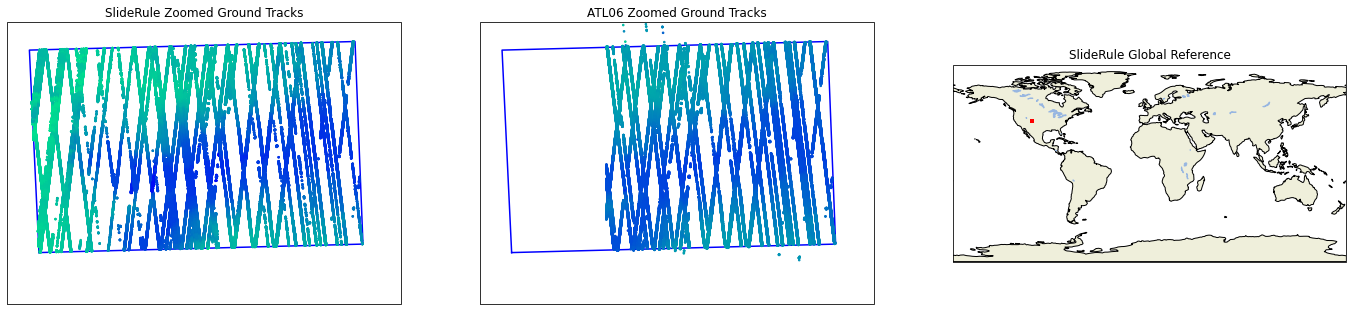

In [7]:
# Create Plot
fig = plt.figure(num=None, figsize=(24, 12))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1 = plt.subplot(131,projection=cartopy.crs.PlateCarree())
ax1.set_title("SlideRule Zoomed Ground Tracks")
ax1.scatter(df["lon"].values, df["lat"].values, s=2.5, c=df["h_mean"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax1.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax1.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot ATL06 Ground Tracks
ax2 = plt.subplot(132,projection=cartopy.crs.PlateCarree())
ax2.set_title("ATL06 Zoomed Ground Tracks")
ax2.scatter(atl06p["longitude"], atl06p["latitude"], s=2.5, c=atl06p["h_li"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax2.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax2.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot SlideRule Global View
ax3 = plt.subplot(133,projection=cartopy.crs.PlateCarree())
ax3.set_title("SlideRule Global Reference")
ax3.scatter(df["lon"].values, df["lat"].values, s=2.5, color='r', zorder=3, transform=cartopy.crs.PlateCarree())
ax3.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES)
ax3.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# Show Plot
plt.show()